In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from torchvision.utils import save_image


In [2]:
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
    properties = torch.cuda.get_device_properties(0)
    compute_capability = f"{properties.major}.{properties.minor}"
    total_memory = properties.total_memory / 1024**3

    print(f"CUDA Device: {device_name}")
    print(f"CUDA Compute Capability: {compute_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    device = torch.device("cpu")
    print("GPU is not available")

PyTorch Version: 2.2.1
CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA Compute Capability: 8.9
Total Memory: 15.70 GB


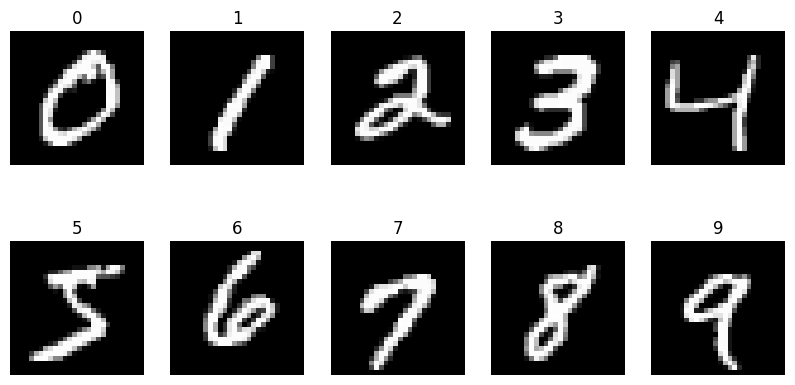

In [3]:
# load MNIST dataset from utils
from utils import get_dataset

(
    channel,
    im_size,
    num_classes,
    class_names,
    mean,
    std,
    train_MNIST_dataset,
    test_MNIST_dataset,
    test_MNIST_dataloader,
    train_MNIST_dataloader,
) = get_dataset("MNIST", "../datasets")

# visualize 10 classes of MNIST (2 by 5)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(
        train_MNIST_dataset.data[train_MNIST_dataset.targets == i][0], cmap="gray"
    )
    ax.set_title(f"{i}")
    ax.axis("off")

In [4]:
from utils import get_network

ConvNet3 = get_network('ConvNetD3', channel, num_classes, im_size)
print(ConvNet3)

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)


In [5]:
"""
n_epochs = 2
lr = 0.01
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)

for epoch in range(n_epochs):
    ConvNet3.train()
    running_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_MNIST_dataloader, 0),
        total=len(train_MNIST_dataloader),
        desc=f"Epoch {epoch+1}",
    )

    total_iterations = len(train_MNIST_dataloader)
    for i, data in enumerate(train_MNIST_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = ConvNet3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        percentage_complete = (i + 1) / total_iterations * 100
        progress_bar.set_postfix(loss=running_loss / (i + 1))
        progress_bar.update(1)
"""

'\nn_epochs = 2\nlr = 0.01\ncriterion = nn.CrossEntropyLoss().to(device)\noptimizer = torch.optim.SGD(ConvNet3.parameters(), lr=lr)\n\nfor epoch in range(n_epochs):\n    ConvNet3.train()\n    running_loss = 0.0\n    progress_bar = tqdm(\n        enumerate(train_MNIST_dataloader, 0),\n        total=len(train_MNIST_dataloader),\n        desc=f"Epoch {epoch+1}",\n    )\n\n    total_iterations = len(train_MNIST_dataloader)\n    for i, data in enumerate(train_MNIST_dataloader, 0):\n        inputs, labels = data\n        inputs, labels = inputs.to(device), labels.to(device)\n\n        optimizer.zero_grad()\n\n        outputs = ConvNet3(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        running_loss += loss.item()\n        percentage_complete = (i + 1) / total_iterations * 100\n        progress_bar.set_postfix(loss=running_loss / (i + 1))\n        progress_bar.update(1)\n'

In [6]:
import MHISTDataset
from torchvision import transforms
to_tensor = transforms.ToTensor()
data_path = '../mhist_dataset/images-split'  

train = MHISTDataset.MHISTDataset(data_path, train=True, transform=to_tensor)
test = MHISTDataset.MHISTDataset(data_path, train=False, transform=None)

images_train = []
for i in range(len(train)):
    img, label = train[i]
    images_train.append(img)

print(images_train[0].shape)

torch.Size([3, 224, 224])


In [7]:
import main_AttentionMatching
import sys

sys.argv = [
    'main_AttentionMatching.py',
    '--init', 'real',
    '--ipc', '10',
    '--model', 'ConvNetD3',
    '--dataset', 'MHIST',
    '--num_eval', '1',
]

file = main_AttentionMatching.main()

eval_it_pool:  [0, 10]

================== Exp 0 ==================
 
Hyper-parameters: 
 {'dataset': 'MHIST', 'model': 'ConvNetD3', 'ipc': 10, 'eval_mode': 'SS', 'num_exp': 1, 'num_eval': 1, 'epoch_eval_train': 1, 'Iteration': 10, 'lr_img': 1, 'lr_net': 0.01, 'batch_real': 256, 'batch_train': 256, 'init': 'real', 'data_path': '../datasets', 'save_path': '../output/', 'task_balance': 0.01, 'method': 'attention_matching', 'device': 'cuda', 'dsa': False}
Evaluation model pool:  ['ConvNetD3']
class c = 0: 1545 real images
class c = 1: 630 real images
real images channel 0, mean = 0.7378, std = 0.1972
real images channel 1, mean = 0.6486, std = 0.2437
real images channel 2, mean = 0.7752, std = 0.1703
initialize synthetic data from random real images
[2024-10-21 23:34:18] training begins
-------------------------
Evaluation
model_train = ConvNetD3, model_eval = ConvNetD3, iteration = 0


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 15.70 GiB of which 95.19 MiB is free. Process 887648 has 15.60 GiB memory in use. Of the allocated memory 15.19 GiB is allocated by PyTorch, and 135.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# load the results images

# plot the results
results = torch.load(file)
syn_imgs = results['data'][0][0]
syn_imgs = torch.clamp(syn_imgs, 0, 1)

# clip the images to [0, 1]
 
# 10 images per class
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[i].permute(1, 2, 0).squeeze(), cmap="gray")
    ax.axis("off")

In [ ]:
sys.argv = [
    'main_AttentionMatching.py',
    '--init', 'noise',
    '--ipc', '10',
    '--model', 'ConvNetD3',
    #'--dataset', 'MNIST',
    '--num_eval', '1',
]

file = main_AttentionMatching.main()
# plot the results
results = torch.load(file)
syn_imgs = results['data'][0][0]
syn_imgs = torch.clamp(syn_imgs, 0, 1)

print(syn_imgs.shape) # = (100, 1, 28, 28)
# 
# 10 images per class
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(syn_imgs[i].permute(1, 2, 0).squeeze(), cmap="gray")
    ax.axis("off")